In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import EfficientNetB4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os

In [2]:
image_size = 224
batch_size = 32
save_model_filename = 'effnet.h5'

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

In [4]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [5]:
train['label'] = train['label'].astype('str')

In [6]:
image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='nearest', 
                                     validation_split=0.2, rescale = 1./255)

test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                      subset='training', color_mode='rgb', batch_size=batch_size, seed=42,
                                                      shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

validation_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', color_mode='rgb', batch_size=batch_size, seed=42,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [8]:
def build_efficientnet_b4():
    
    model = Sequential()
    model.add(EfficientNetB4(input_shape = (image_size,image_size,3), include_top = False, weights = None))
    model.load_weights('imagenet')
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

In [9]:
model = build_efficientnet_b4()

In [16]:
model.save(save_model_filename)

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 18,134,116
Trainable params: 18,008,909
Non-trainable params: 125,207
______________________________________

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00001)

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


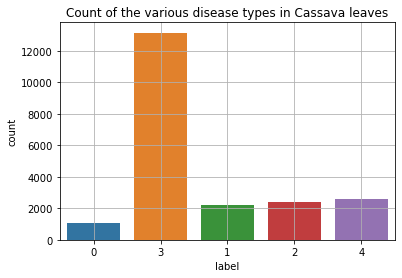

In [13]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

In [14]:
# total = len(train)
# zero, one, two, three, four = np.bincount(train['label'])

# weight_for_0 = (1 / zero) * (total / 2.0)
# weight_for_1 = (1 / one) * (total / 2.0)
# weight_for_2 = (1 / two) * (total / 2.0)
# weight_for_3 = (1 / three) * (total / 2.0)
# weight_for_4 = (1 / four) * (total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))
# print('Weight for class 3: {:.2f}'.format(weight_for_3))
# print('Weight for class 4: {:.2f}'.format(weight_for_4))

In [15]:
epoch = 15

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
#     class_weight=class_weight
)

Epoch 1/15


ResourceExhaustedError:  OOM when allocating tensor with shape[32,7,7,1632] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/efficientnetb4/block6d_activation/mul-0-2-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_53865]

Function call stack:
train_function


In [ ]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [ ]:
pred = model.predict(validation_generator)
predictions = np.argmax(pred, axis=1)
actual = validation_generator.classes

from sklearn.metrics import classification_report

report = classification_report(actual, predictions, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

In [ ]:
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [ ]:
test_path = '../input/cassava-leaf-disease-classification/test_images'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [ ]:
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

In [ ]:
output = model.predict(test_generator)

In [ ]:
submission = pd.DataFrame()
submission['image_id'] = list(os.listdir(test_path))
submission['label'] = np.argmax(output, axis=1)
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()

In [ ]:
model.save(save_model_filename)